# Using AutoEncoder as a Feature Extraction Tool

We have been using AE directly for the classifcation purposes, now we use it as a feature extraction tool.

Original post can be found [here](https://blog.myyellowroad.com/unsupervised-sentence-representation-with-deep-learning-104b90079a93).

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# from textblob import TextBlob
import numpy as np

In [2]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)

In [3]:
review_df = pd.read_csv('./amazon_data_20191202/processed.csv', index_col=0)
review_df.head()

,user_id,prod_id,date,text,review_id,rating,label
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,923020141208,3.0,-1
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,924020130516,3.0,-1
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,925020130701,4.0,-1
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,926020110728,4.0,-1
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...,927020101101,4.0,-1


In [4]:
review_df.dtypes

user_id        int64
prod_id        int64
date          object
text          object
review_id      int64
rating       float64
label          int64
dtype: object

In [5]:
review_df['label'].unique()

array([-1,  1])

In [6]:
class_dict = {-1:0, 1:1}
review_df['label'] = review_df['label'].map(class_dict)
review_df['label'].unique()

array([0, 1])

In [7]:
sampled0 = review_df[review_df['label'] == 0].sample(n=10000, random_state=2019)
sampled1 = review_df[review_df['label' ]== 1].sample(n=10000, random_state=2019)
sampled = pd.concat([sampled0, sampled1])

In [8]:
sampled.shape

(20000, 7)

## parse sentences

In [9]:
#parse all sentences
from nltk.tokenize import sent_tokenize

sentences = []
for i in sampled['text'].values:
    for j in sent_tokenize(i):
        sentences.append(j)
        
sentences[:2]

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


['At the moment Perilla is my favorite restaurant in this area.',
 'All their dishes are pretty solid.']

# preprocess for keras

In [10]:
#preprocess for keras
num_words=5000
maxlen=30

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [12]:
tokenizer = Tokenizer(num_words = num_words, split=' ')

tokenizer.fit_on_texts(sentences)
seqs = tokenizer.texts_to_sequences(sentences)
pad_seqs = []
for i in seqs:
    if len(i)>4:
        pad_seqs.append(i)
pad_seqs = pad_sequences(pad_seqs,maxlen)
pad_seqs[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   31,    1, 1240,
        3131,    8,   17,  188,   61,   11,   15,  233],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   36,   54,  179,   29,  112,  602]], dtype=int32)

# The model

In [13]:
#The model
embed_dim = 128
latent_dim = 64
batch_size = 128

In [14]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, concatenate, GRU, RepeatVector
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.models import Model, load_model
#from keras.layers import Input, Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers, optimizers

In [15]:
#### Encoder Model ####
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
# Word embeding for encoder (ex: Issue Body)
x = emb_layer(encoder_inputs)
#state_h = GRU(latent_dim*2, name='Encoder-First-GRU', return_sequences=True)(x)
state_h = GRU(latent_dim, name='Encoder-Last-GRU')(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
#### Decoder Model ####
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_gru = GRU(latent_dim, return_sequences=True, name='Decoder-GRU-before')
#decoder_gru = GRU(latent_dim*2, return_sequences=True, name='Decoder-GRU-second')
decoder_gru_output = decoder_gru(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_gru_output)

In [17]:
#### Seq2Seq Model ####
#seq2seq_decoder_out = decoder_model([decoder_inputs, seq2seq_encoder_out])
seq2seq_Model = Model(encoder_inputs,decoder_outputs )
seq2seq_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 30)                0         
_________________________________________________________________
Encoder-Model (Model)        (None, 64)                677056    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
Decoder-GRU-before (GRU)     (None, 30, 64)            24768     
_________________________________________________________________
Final-Output-Dense-before (D (None, 30, 5000)          325000    
Total params: 1,026,824
Trainable params: 1,026,824
Non-trainable params: 0
_________________________________________________________________


In [18]:
seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

In [20]:
checkpointer = ModelCheckpoint(filepath="seq2seq_model-0103.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [21]:
history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
          batch_size=batch_size,
          epochs=50,
          validation_split=0.10, 
          callbacks=[checkpointer, tensorboard, es]).history

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 114078 samples, validate on 12676 samples
Epoch 1/50
114078/114078 [==============================] - 69s 609us/step - loss: 3.8097 - val_loss: 3.7300
Epoch 2/50
114078/114078 [==============================] - 68s 596us/step - loss: 3.6785 - val_loss: 3.7295
Epoch 3/50
114078/114078 [==============================] - 69s 605us/step - loss: 3.6785 - val_loss: 3.7302
Epoch 4/50
 33280/114078 [=======>......................] - ETA: 46s - loss: 3.6793

KeyboardInterrupt: 

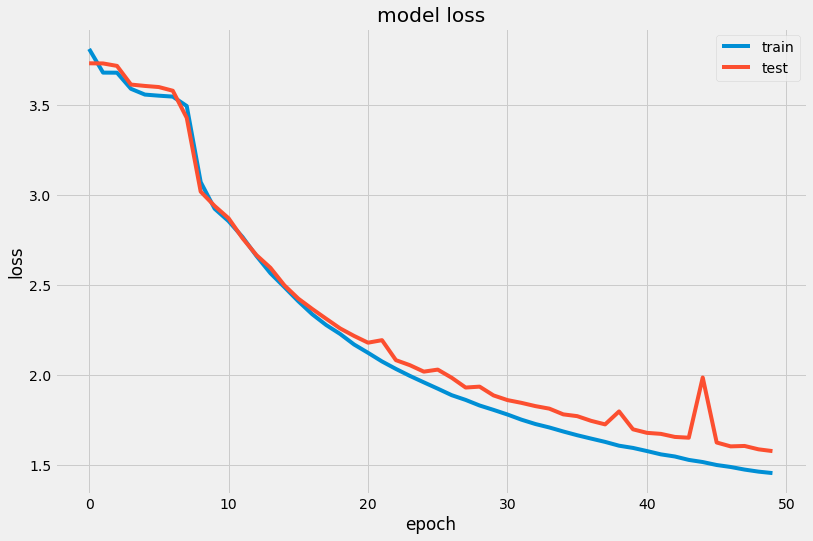

In [28]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

# Feature extraction

In [30]:
#Feature extraction
contents = tokenizer.texts_to_sequences(review_df['text'].values)
contents = pad_sequences(contents,maxlen=maxlen)

x = encoder_model.predict(contents)

In [31]:
np.random.seed(2019)

msk = np.random.rand(len(review_df)) < 0.9
msk

array([False,  True,  True, ...,  True, False,  True])

In [32]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(review_df['label'].values)
y[:2]

array([0, 0])

In [33]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.36      0.00      0.00      3642
          1       0.90      1.00      0.95     32272

avg / total       0.84      0.90      0.85     35914



In [36]:
lr.score(X_test, y_test)

0.8984240129197527

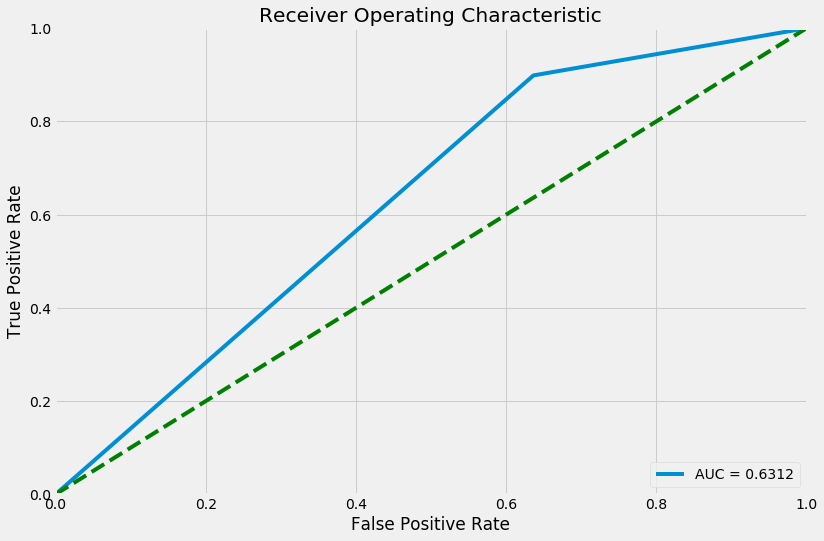

In [37]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

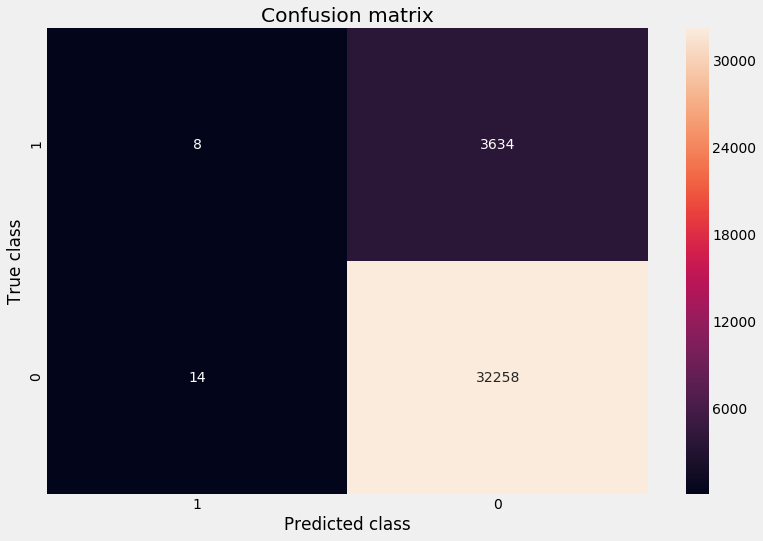

In [38]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [39]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3642
          1       0.90      1.00      0.95     32272

avg / total       0.81      0.90      0.85     35914



/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.86%


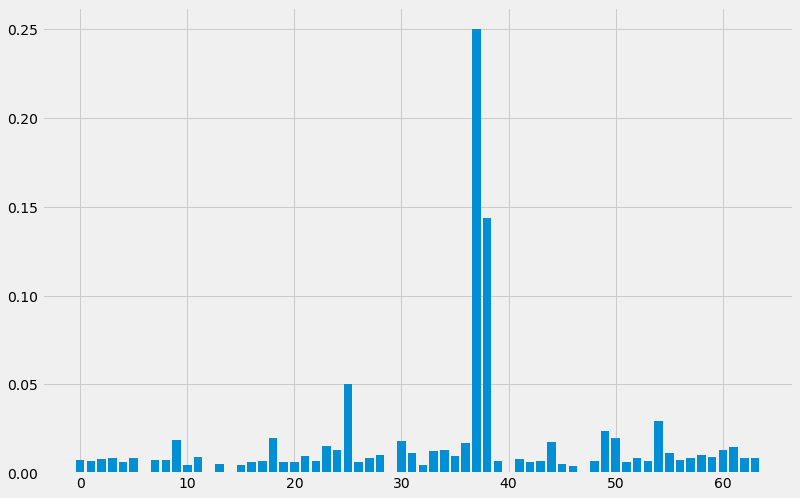

In [41]:
# print(model.feature_importances_)
# plot
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


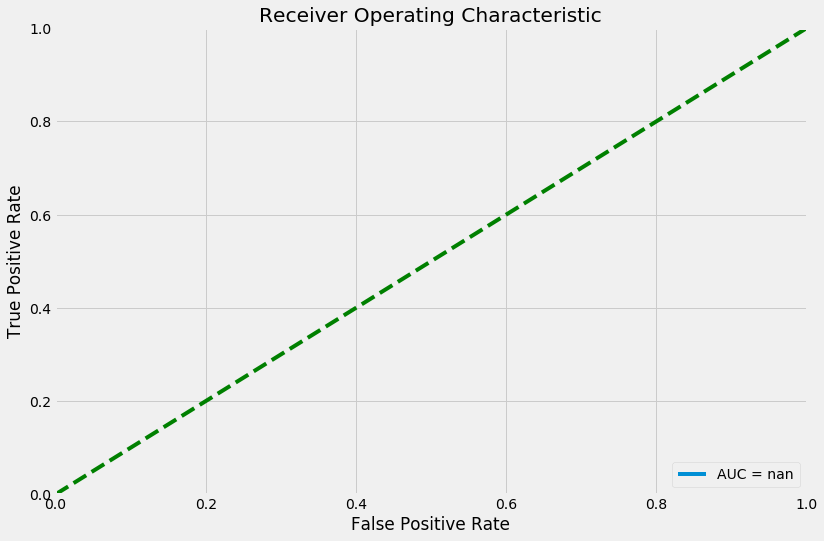

In [42]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

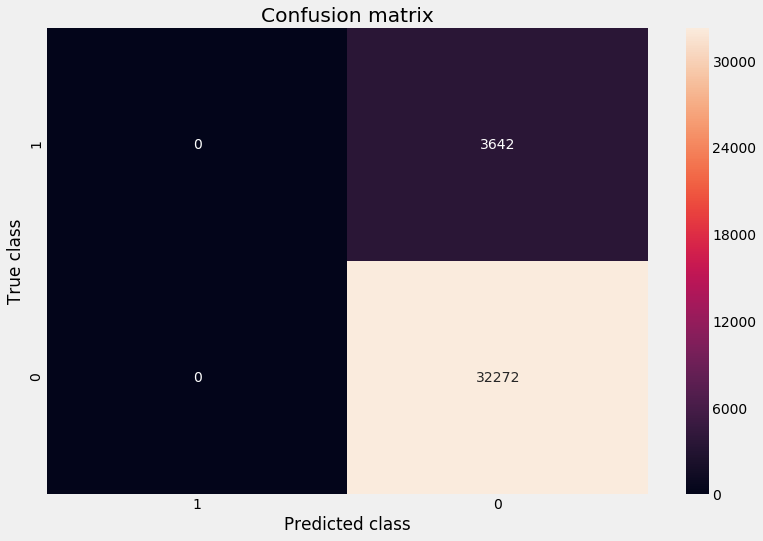

In [43]:
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Baseline Model

In [44]:
import gensim

In [45]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In [49]:
x = np.random.rand(len(sampled), 300)
len(x)

20000

In [52]:


for i in range(len(sampled)):
    k = 0
    non = 0
    values = np.zeros(300)
    for j in sampled['text'].iloc[i].split(' '):
        if j in w2v:
            values+= w2v[j]
            k+=1
    if k > 0:
        x[i,:]=values/k
    else: 
        non+=1

In [53]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20000 but corresponding boolean dimension is 358957

In [37]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.88      0.85      0.87        89
          1       0.88      0.91      0.89       107

avg / total       0.88      0.88      0.88       196



In [38]:
lr.score(X_test,y_test)

0.8826530612244898

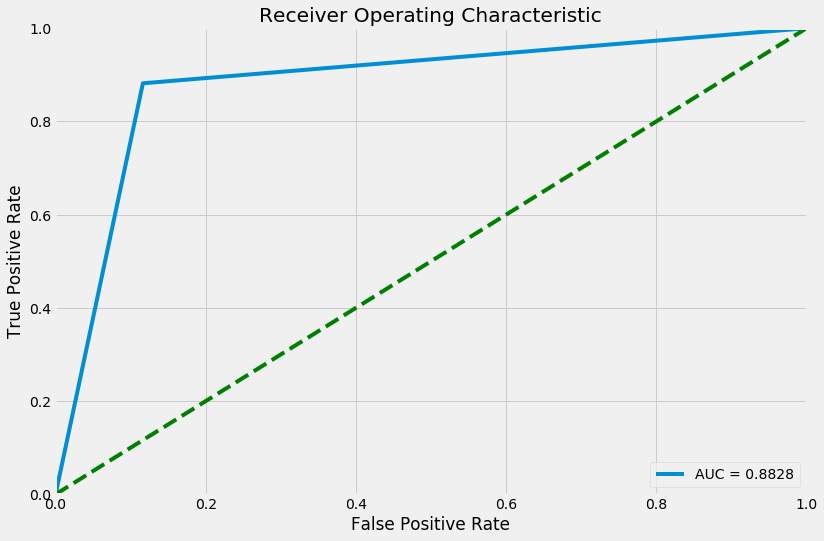

In [39]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

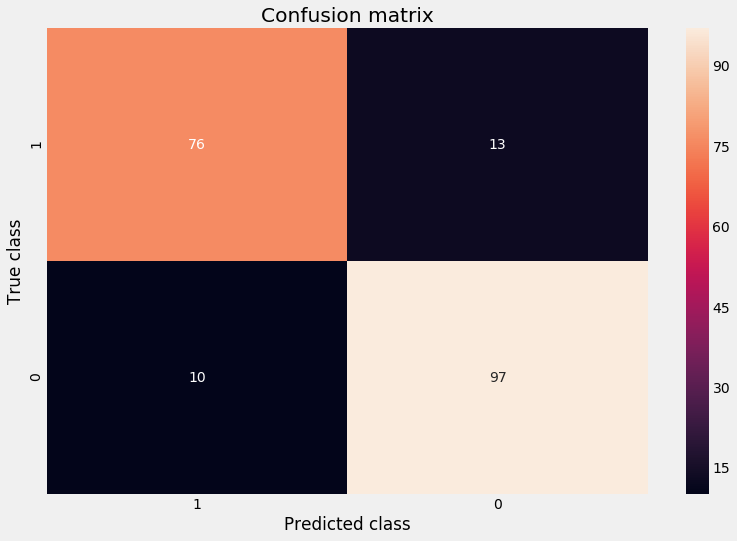

In [40]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [41]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [42]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [43]:
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.86      0.88      0.87        89
          1       0.90      0.88      0.89       107

avg / total       0.88      0.88      0.88       196



In [44]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.76%


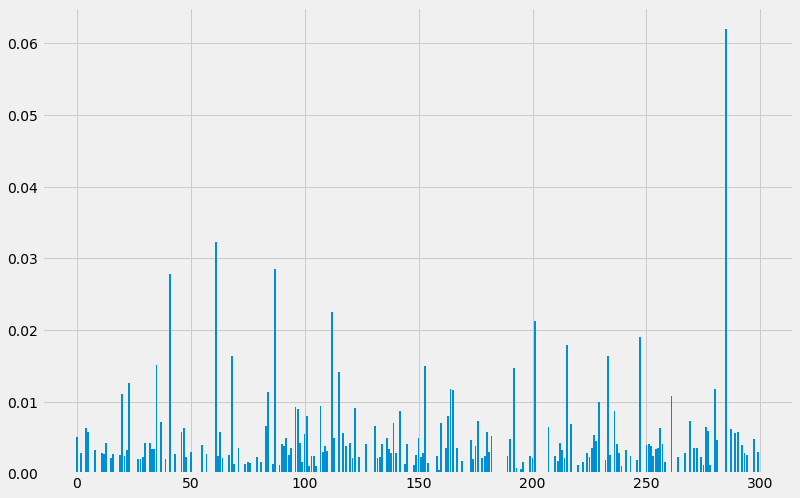

In [45]:
# print(model.feature_importances_)
# plot
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

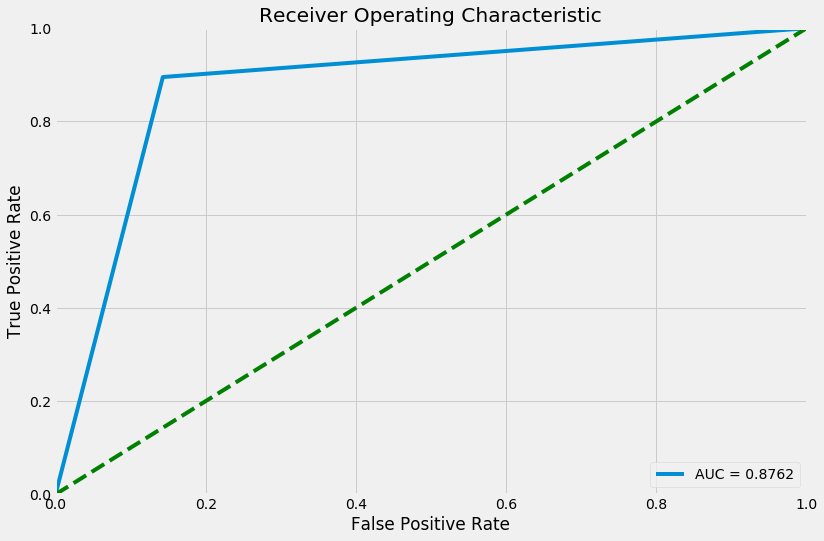

In [46]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

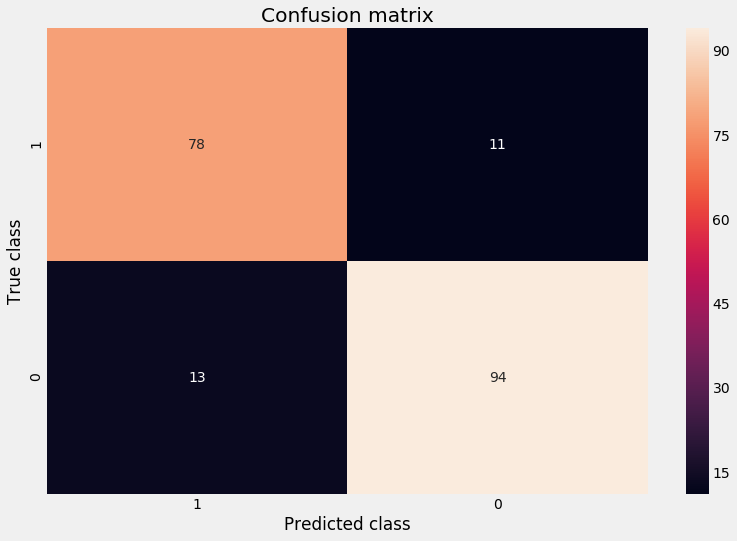

In [47]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Skip-Thought Vectors

In [68]:
#Build x and y
num_words=3000
maxlen=25
tokenizer = Tokenizer(num_words = num_words, split=' ')
tokenizer.fit_on_texts(sentences)
seqs = tokenizer.texts_to_sequences(sentences)
pad_seqs = pad_sequences(seqs,maxlen)
x_skip = []
y_before = []
y_after = []

In [69]:
for i in range(1,len(seqs)-1):
    if len(seqs[i])>4:
        x_skip.append(pad_seqs[i].tolist())
        y_before.append(pad_seqs[i-1].tolist())
        y_after.append(pad_seqs[i+1].tolist())

In [70]:
x_before = np.matrix([[0]+i[:-1] for i in y_before])
x_after =np.matrix([[0]+i[:-1] for i in y_after])
x_skip = np.matrix(x_skip)
y_before = np.matrix(y_before)
y_after = np.matrix(y_after)

In [71]:
#Building the model

embed_dim = 128
latent_dim = 64
batch_size = 32

In [72]:
#### Encoder Model ####
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [73]:
#### Decoder Model ####
decoder_inputs_before = Input(shape=(None,), name='Decoder-Input-before')  # for teacher forcing
dec_emb_before = emb_layer(decoder_inputs_before)
decoder_gru_before = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU-before')
decoder_gru_output_before, _ = decoder_gru_before(dec_emb_before, initial_state=seq2seq_encoder_out)
decoder_dense_before = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs_before = decoder_dense_before(decoder_gru_output_before)
decoder_inputs_after = Input(shape=(None,), name='Decoder-Input-after')  # for teacher forcing
dec_emb_after = emb_layer(decoder_inputs_after)
decoder_gru_after = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU-after')
decoder_gru_output_after, _ = decoder_gru_after(dec_emb_after, initial_state=seq2seq_encoder_out)
decoder_dense_after = Dense(num_words, activation='softmax', name='Final-Output-Dense-after')
decoder_outputs_after = decoder_dense_after(decoder_gru_output_after)

In [74]:
#### Seq2Seq Model ####
seq2seq_Model = Model([encoder_inputs, decoder_inputs_before,decoder_inputs_after], [decoder_outputs_before,decoder_outputs_after])
seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')
seq2seq_Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input-before (InputLaye (None, None)         0                                            
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 25)           0                                            
__________________________________________________________________________________________________
Decoder-Input-after (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
Body-Word-Embedding (Embedding) (None, 25, 128)      384000      Decoder-Input-before[0][0]       
                                                                 Decoder-Input-after[0][0]        
__________

In [75]:
history = seq2seq_Model.fit([x_skip,x_before, x_after], [np.expand_dims(y_before, -1),np.expand_dims(y_after, -1)],
          batch_size=batch_size,
          epochs=50,
          validation_split=0.10,
          callbacks=[checkpointer, tensorboard, es]).history

Train on 2061 samples, validate on 229 samples
Epoch 1/50
2061/2061 [==============================] - 7s 3ms/step - loss: 9.7952 - Final-Output-Dense-before_loss: 4.8629 - Final-Output-Dense-after_loss: 4.9323 - val_loss: 6.5585 - val_Final-Output-Dense-before_loss: 3.3289 - val_Final-Output-Dense-after_loss: 3.2295
Epoch 2/50
2061/2061 [==============================] - 5s 3ms/step - loss: 5.8403 - Final-Output-Dense-before_loss: 2.9154 - Final-Output-Dense-after_loss: 2.9249 - val_loss: 6.2876 - val_Final-Output-Dense-before_loss: 3.1665 - val_Final-Output-Dense-after_loss: 3.1211
Epoch 3/50
2061/2061 [==============================] - 5s 3ms/step - loss: 5.2526 - Final-Output-Dense-before_loss: 2.6147 - Final-Output-Dense-after_loss: 2.6379 - val_loss: 5.6752 - val_Final-Output-Dense-before_loss: 2.8813 - val_Final-Output-Dense-after_loss: 2.7939
Epoch 4/50
2061/2061 [==============================] - 5s 3ms/step - loss: 4.9096 - Final-Output-Dense-before_loss: 2.4516 - Final-Outpu

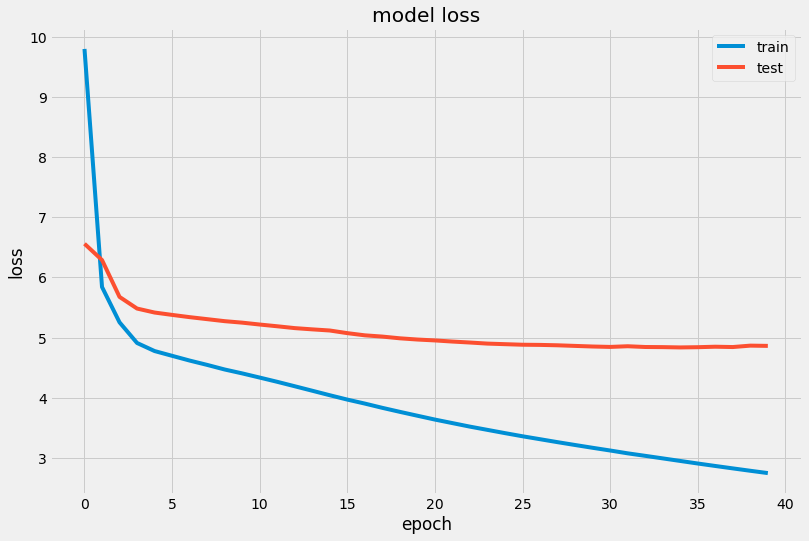

In [76]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [77]:
#Feature extraction
contents = tokenizer.texts_to_sequences(review_df['CONTENT'].values)
contents = pad_sequences(contents,maxlen=maxlen)

x = encoder_model.predict(contents)

In [78]:
X_train,y_train,X_test,y_test = x[msk],y[msk],x[~msk],y[~msk]

In [79]:
#Train the model
from sklearn.metrics import classification_report
lr = LogisticRegression().fit(X_train,y_train)
#lr.score(X_test,y_test)
y_pred = lr.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.66      0.67      0.67        89
          1       0.72      0.71      0.72       107

avg / total       0.69      0.69      0.69       196



In [80]:
lr.score(X_test,y_test)

0.6938775510204082

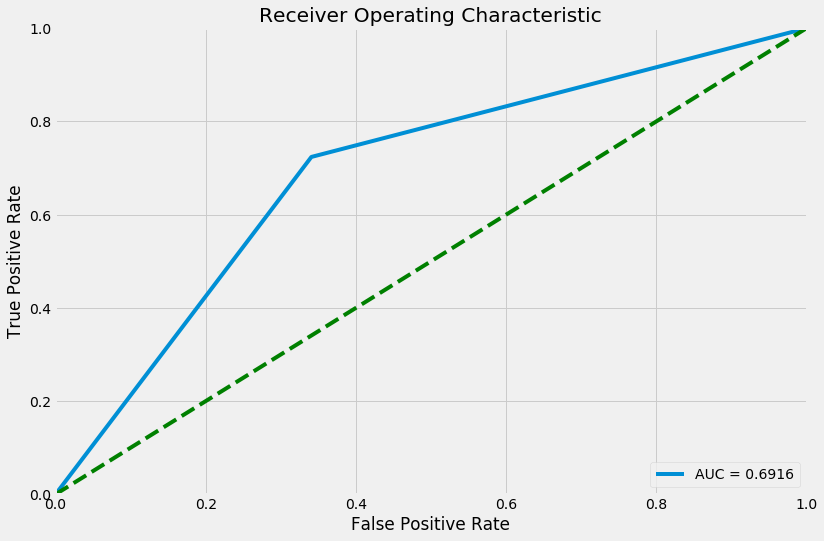

In [81]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

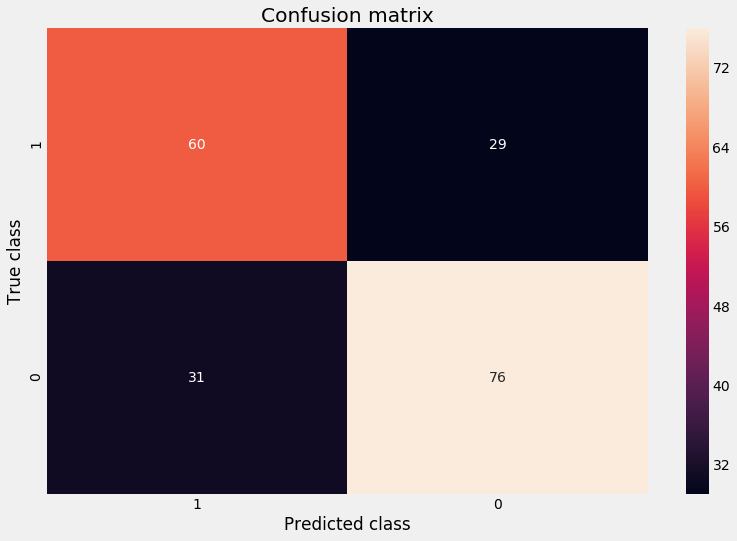

In [82]:
import seaborn as sns
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [83]:
from xgboost import XGBClassifier

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.77      0.72      0.74        89
          1       0.78      0.82      0.80       107

avg / total       0.78      0.78      0.77       196



/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [84]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.55%


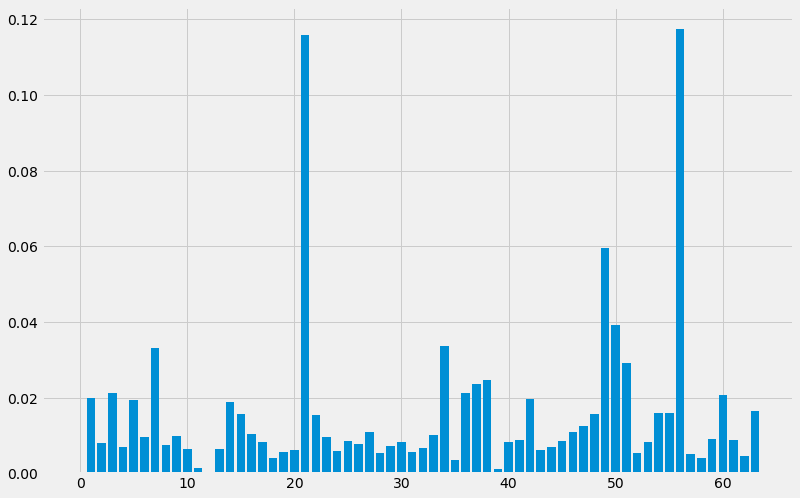

In [85]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

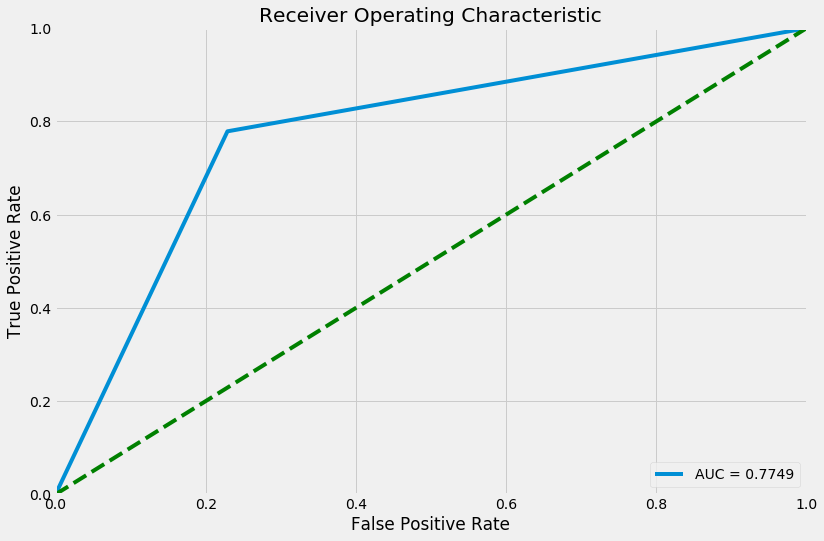

In [86]:
fpr, tpr, thresholds = roc_curve(y_pred,y_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

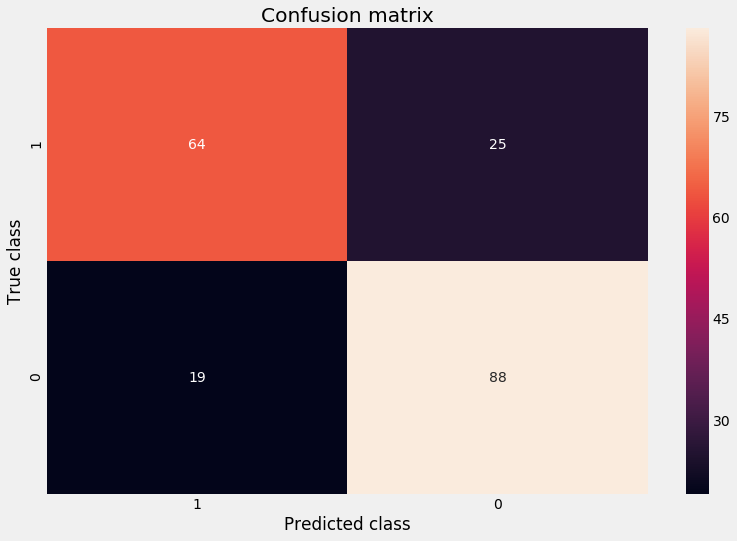

In [87]:
labels = ['1', '0']
#y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, y_pred)
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()